# Read In Data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [2]:
# read in train and validate set
df = pd.read_csv('Train_and_Validate_EEG.csv')

# Data Processing

## Data Cleaning and Transformation

In [3]:
# drop unnamed column between psd columns and coherence columns
df.drop('Unnamed: 122', axis=1, inplace=True)

# Check for missing values
df.isna().sum().sort_values(ascending = False).head(3)

# fill in missing values for iq and education with the average value
df['education'] = df['education'].fillna(df['education'].mean())
df['IQ'] = df['IQ'].fillna(df['IQ'].mean()) 

# one-hot encode sex
df = pd.get_dummies(df, columns=['sex'], dtype=int, drop_first=True)

## Data Investigation and Visualization

float64    1143
object        3
int64         2
Name: count, dtype: int64
main.disorder
Mood disorder                         250
Addictive disorder                    171
Schizophrenia                         109
Trauma and stress related disorder    106
Anxiety disorder                       91
Healthy control                        87
Obsessive compulsive disorder          38
Name: count, dtype: int64


<AxesSubplot: ylabel='main.disorder'>

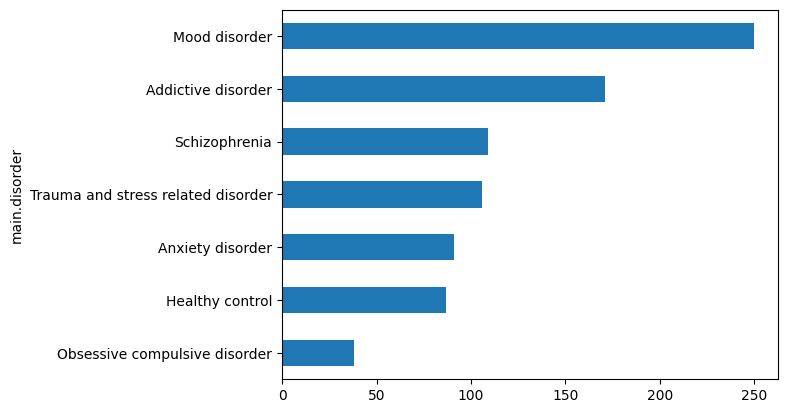

In [4]:
# check data types
print(df.dtypes.value_counts())

# check number of disorders
print(df['main.disorder'].value_counts())

# Plot number of disorders for each category
df['main.disorder'].value_counts().sort_values().plot(kind = 'barh')

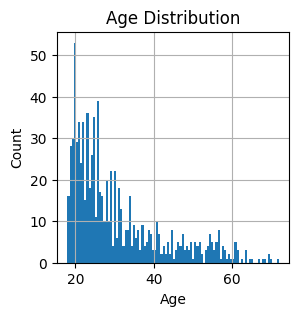

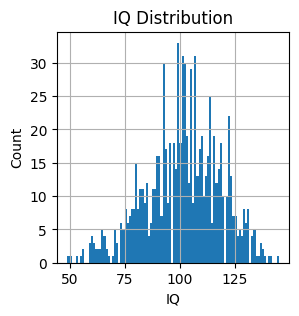

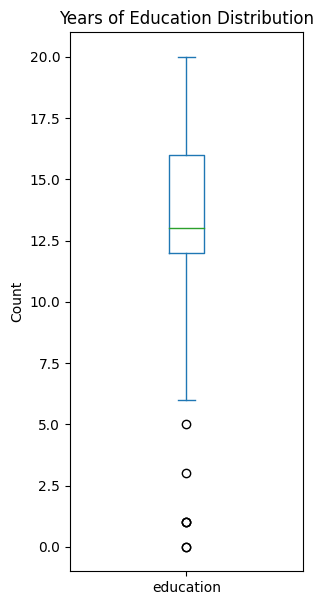

In [5]:
# make histogram for age distribution
plt.figure(figsize=(3, 3))
df["age"].hist(bins=100)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")

# make histogram for IQ distribution
plt.figure(figsize=(3, 3))
df["IQ"].hist(bins=100)
plt.xlabel("IQ")
plt.ylabel("Count")
plt.title("IQ Distribution")

# make boxplot for years of eduction distribution
plt.figure(figsize=(3,7))
df["education"].plot(kind="box")
plt.title("Years of Education Distribution")
plt.ylabel("Count")
plt.show()

## Feature Engineering

In [6]:
# Selecting psd data
psd = df.loc[:, 'AB.A.delta.a.FP1':'AB.F.gamma.s.O2']

# Creating dictionary that will store our results before converting into DataFrame
psd_aggregate_dict = {}

# Different categories used to identify the regions and types of coherence connections
# The index of the region corresponds to the index of the set of electrodes.
zone_names = ['FP', 'F', 'T', 'C', 'P', 'O']
electrode_names = [['a.FP1', 'b.FP2'], ['c.F7', 'd.F3', 'e.Fz', 'f.F4', 'g.F8'], ['h.T3','l.T4','m.T5','q.T6'], ['i.C3','j.Cz','k.C4',], ['n.P3','o.Pz','p.P4'], ['r.O1','s.O2']]
band_names = ['A.delta', 'B.theta', 'C.alpha', 'D.beta', 'E.highbeta', 'F.gamma']

# Iterating over the frequency bands
for band in band_names:
    
    # Iterating over the different regions
    for i in range(6):
        psd_column_name = 'AB.'+band+'.'+zone_names[i]
        psd_aggregate_dict[psd_column_name] = np.zeros(len(psd))
        
        # Iterating over every electrode in each region
        for j in range(len(electrode_names[i])):
            psd_aggregate_dict[psd_column_name] += psd['AB.'+band+'.'+electrode_names[i][j]]

# Converting dictionary into DataFrame
psd_aggregate = pd.DataFrame(psd_aggregate_dict)
psd_aggregate

,AB.A.delta.FP,AB.A.delta.F,AB.A.delta.T,AB.A.delta.C,AB.A.delta.P,AB.A.delta.O,AB.B.theta.FP,AB.B.theta.F,AB.B.theta.T,AB.B.theta.C,...,AB.E.highbeta.T,AB.E.highbeta.C,AB.E.highbeta.P,AB.E.highbeta.O,AB.F.gamma.FP,AB.F.gamma.F,AB.F.gamma.T,AB.F.gamma.C,AB.F.gamma.P,AB.F.gamma.O
0,95.377594,150.805436,59.864117,89.852543,68.348342,41.146051,36.934024,100.968992,46.457462,75.655876,...,13.207038,22.212076,13.351225,7.003263,7.680867,21.952687,10.829030,12.428084,10.355322,8.364827
1,56.946582,95.616100,26.773867,45.138319,28.241197,7.233696,21.658390,59.117340,19.189958,39.131004,...,5.238396,10.063846,5.223024,4.503153,9.565033,38.234226,8.635334,16.488242,7.018361,8.749073
2,59.296406,172.297280,91.668111,89.321282,86.361408,45.906623,43.706511,113.985722,61.044021,68.263757,...,13.414056,7.718096,7.428850,6.656960,4.559417,13.144761,21.404412,7.249077,8.537004,10.384307
3,28.257927,60.323875,24.358222,33.021924,25.878258,11.914385,13.401144,32.229871,12.289824,18.591089,...,12.400121,9.756221,8.724257,5.419428,12.780891,31.840146,25.567730,18.421182,17.452897,11.365790
4,45.701521,111.018209,74.437413,70.724344,69.207682,35.632263,42.005506,108.655031,47.757807,68.062632,...,4.825423,4.977962,4.182971,2.302236,4.165723,9.874787,5.960478,5.606211,5.132754,2.890287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,45.232440,90.860074,43.412410,41.777696,34.371832,16.331762,27.505011,63.037441,20.036477,29.318156,...,8.142162,6.408792,6.788560,11.496402,7.169990,16.762536,14.968952,9.044182,10.822714,22.513123
848,27.183258,93.093073,49.130022,45.112674,61.650329,24.158418,22.318616,66.834563,26.205599,39.597970,...,5.282800,6.641154,5.481632,2.683868,10.518804,33.358227,8.439813,15.063430,9.364465,4.042318
849,31.789815,58.520975,33.719365,38.182920,42.073994,14.721419,17.383560,34.049610,16.984534,25.866671,...,3.320175,4.522759,3.322944,1.832680,2.634774,6.451391,4.467643,6.060888,4.058746,1.841964
850,47.152159,125.082780,61.630728,64.658611,61.801589,29.291960,62.869407,164.496204,77.651038,87.760483,...,4.799515,4.408173,4.758434,3.279130,2.232989,5.444301,3.411862,3.198698,3.688839,2.530521


In [7]:
# Selecting coherence data
coherence = df.loc[:, 'COH.A.delta.a.FP1.b.FP2':]

# Creating dictionary that will store our results before converting into DataFrame
coherence_hemispheres_aggregate_dict = {}

# Different categories used to identify the regions and types of coherence connections
# The index of the region corresponds to the index of the set of electrodes.
# The parity of the index of electrodes in the region corresponds to the hemisphere location.
zone_names = ['FP','F', 'T', 'C', 'P', 'O']
electrode_names = [['a.FP1', 'b.FP2'], ['c.F7', 'f.F4', 'd.F3', 'g.F8', 'e.Fz'], ['h.T3','l.T4','m.T5','q.T6'], ['i.C3','k.C4','j.Cz'], ['n.P3','p.P4','o.Pz'], ['r.O1','s.O2']]
band_names = ['A.delta', 'B.theta', 'C.alpha', 'D.beta', 'E.highbeta', 'F.gamma']

# Iterating over the frequency bands
for band in band_names:
    
    # Iterating over the different regions, taking care to not double count coherences
    for i in range(6):
        for j in range(i,6):
            coh_column_name = 'COH.hemispheres.'+band+'.'+zone_names[i]+'.'+zone_names[j]
            coherence_hemispheres_aggregate_dict[coh_column_name] = np.zeros(len(coherence))
           
            # Iterating over every electrode coherence combination
            for a in range(len(electrode_names[i])):
                for b in range(len(electrode_names[j])):
                    
                    # Inter-region coherence
                    if i!=j:

                        # Counting coherences between electrodes in different hemispheres as this has been shown  to be a great indicator 
                        # of mental disorders in the speciality literature. Electrodes in different hemispheres have different index parities.
                        if (a+b)%2 ==1:
                            try:
                                coherence_hemispheres_aggregate_dict[coh_column_name] +=coherence['COH.'+band+'.'+electrode_names[i][a]+'.'+electrode_names[j][b]].values
                            except:
                                coherence_hemispheres_aggregate_dict[coh_column_name] +=coherence['COH.'+band+'.'+electrode_names[j][b]+'.'+electrode_names[i][a]].values
                    
                    # Intra-region coherence
                    elif(a<b):
                        if (a+b)%2 == 1:
                            try:
                                coherence_hemispheres_aggregate_dict[coh_column_name] +=coherence['COH.'+band+'.'+electrode_names[i][a]+'.'+electrode_names[j][b]].values
                            except:
                                coherence_hemispheres_aggregate_dict[coh_column_name] +=coherence['COH.'+band+'.'+electrode_names[j][b]+'.'+electrode_names[i][a]].values

# Converting dictionary into DataFrame
coherence_hemispheres_aggregate = pd.DataFrame(coherence_hemispheres_aggregate_dict)
coherence_hemispheres_aggregate

,COH.hemispheres.A.delta.FP.FP,COH.hemispheres.A.delta.FP.F,COH.hemispheres.A.delta.FP.T,COH.hemispheres.A.delta.FP.C,COH.hemispheres.A.delta.FP.P,COH.hemispheres.A.delta.FP.O,COH.hemispheres.A.delta.F.F,COH.hemispheres.A.delta.F.T,COH.hemispheres.A.delta.F.C,COH.hemispheres.A.delta.F.P,...,COH.hemispheres.F.gamma.T.T,COH.hemispheres.F.gamma.T.C,COH.hemispheres.F.gamma.T.P,COH.hemispheres.F.gamma.T.O,COH.hemispheres.F.gamma.C.C,COH.hemispheres.F.gamma.C.P,COH.hemispheres.F.gamma.C.O,COH.hemispheres.F.gamma.P.P,COH.hemispheres.F.gamma.P.O,COH.hemispheres.F.gamma.O.O
0,85.056680,368.599409,160.676425,175.323890,115.063990,36.120806,450.853259,477.626507,500.013087,360.380091,...,92.789121,243.957056,258.400313,105.377181,142.496839,241.933698,93.265229,146.602522,153.545172,51.237679
1,84.994328,376.174172,143.238669,195.607962,133.310978,37.126441,457.610636,373.208881,504.618252,343.854919,...,153.211136,313.906124,299.492631,176.234293,165.817566,273.117559,152.041722,135.526475,178.971032,63.630547
2,43.406463,164.808154,23.530955,69.065977,25.331891,4.061623,232.734323,121.571559,281.445788,136.340133,...,12.798113,168.275446,182.652306,105.211093,157.800992,286.168085,154.158667,157.190233,191.106747,80.202968
3,71.056801,209.266085,56.304375,92.112772,61.180392,11.013526,214.098934,176.819372,255.943916,202.024061,...,50.809086,125.968588,175.802269,88.259949,112.194028,189.251076,60.433755,132.585708,135.517453,54.662177
4,53.959370,153.362761,48.540004,50.171785,31.584838,11.191091,152.332848,119.032470,133.810042,97.463924,...,26.896128,77.435133,94.100034,69.411387,42.955458,100.609689,46.946559,65.589861,87.418491,41.015604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,82.936259,328.177258,131.204985,161.039358,107.854785,64.395835,381.658478,362.074978,406.218929,300.763972,...,204.682472,342.398048,358.316709,200.987662,138.696985,266.713382,146.235744,144.218789,187.666505,72.506823
848,71.326440,208.481085,53.440116,92.697780,48.688013,7.817260,280.718689,192.387092,352.230568,227.790343,...,47.187958,134.749388,174.564325,90.587250,123.803411,195.795645,65.309043,134.359572,134.807540,54.297598
849,59.618728,246.536456,76.723830,127.863811,84.003031,26.186316,309.455264,218.117599,366.616950,259.621066,...,182.131391,321.910649,349.420958,235.663735,157.798839,284.088274,180.189798,158.115805,218.800773,80.363086
850,73.702240,215.060955,31.036323,73.040539,41.461717,8.057010,196.527742,69.512965,191.627697,130.092215,...,43.504826,115.773722,153.750824,74.592005,79.671297,155.323826,67.132382,99.601669,110.898514,49.097135


In [8]:
# create features matrix
X = pd.DataFrame()

# add sex, age, education, and iq to features matrix
X['sex_M'] = df['sex_M']
X['age'] = df['age']
X['education'] = df['education']
X['IQ'] = df['IQ']

# add psd aggregates and coherence aggregates (see above blocks) to features matrix
X = pd.concat([X, psd_aggregate, coherence_hemispheres_aggregate], axis=1)

# print intitial shape of features matrix
print("Initial shape of features matrix:", X.shape)

Initial shape of features matrix: (852, 166)


In [9]:
# create target vector
y = df['main.disorder']

# print shape of target vector (to confirm dimension matches features matrix)
print("Shape of target vector:",y.shape)

# separate the dataframe based on main condition
mood = X[y == "Mood disorder"]
healthy = X[y == "Healthy control"]
schizo = X[y == "Schizophrenia"]
ocd = X[y == "Obsessive compulsive disorder"]
addict = X[y == "Addictive disorder"]
trauma = X[y == "Trauma and stress related disorder"]
anxiety = X[y == "Anxiety disorder"]

# perform ANOVA test to see which features are statistically significant
f_value, p_value = stats.f_oneway(mood, healthy, schizo, ocd, addict, trauma, anxiety)
p_value_df = pd.DataFrame({'Feature': X.columns, 'f_value': f_value, 'p_value': p_value})

# remove features that are not statistically significant
p_value_df = p_value_df.loc[p_value_df['p_value'] < 0.05]
significant_features = p_value_df['Feature'].tolist()
X = X[significant_features]

# print new shape of features matrix
print("Shape of significant features matrix:", X.shape)

Shape of target vector: (852,)
Shape of significant features matrix: (852, 27)


         Feature    f_value       p_value
3             IQ  26.866623  2.171179e-29
0          sex_M  25.323543  9.776524e-28
22  AB.D.beta.FP   6.945516  3.208316e-07
23   AB.D.beta.F   6.774764  4.998514e-07
9   AB.A.delta.O   6.425171  1.236744e-06
2      education   6.323672  1.607978e-06
1            age   6.209789  2.158023e-06
24   AB.D.beta.T   6.104018  2.835283e-06
25   AB.D.beta.C   5.746025  7.124299e-06
6   AB.A.delta.T   5.344036  1.994307e-05


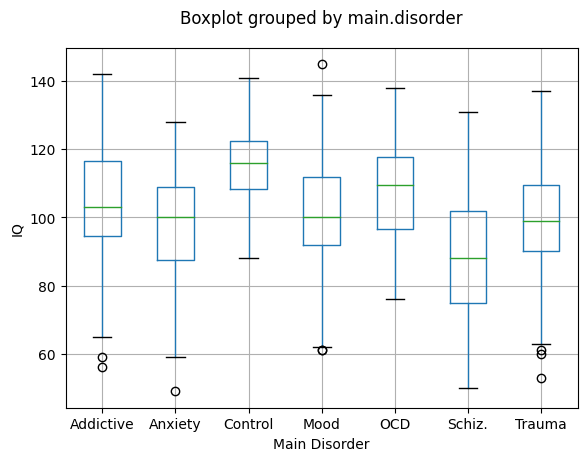

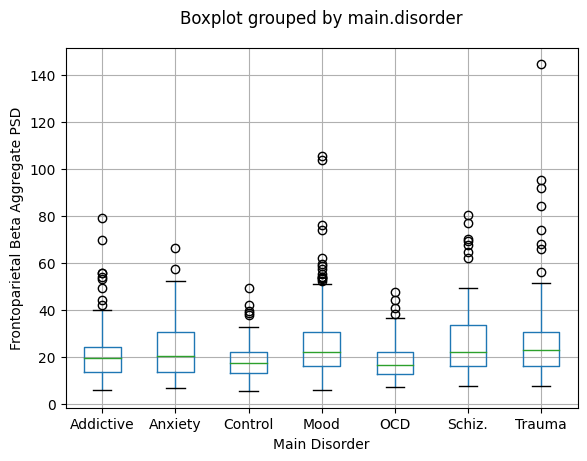

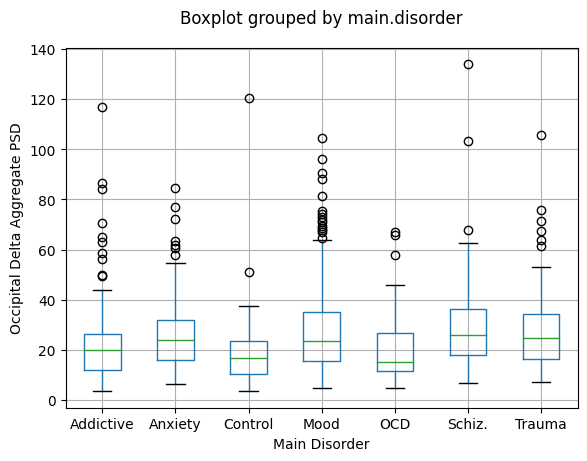

In [10]:
# sort features based on p-values (ascending order)
sorted_features = p_value_df.sort_values(by='p_value')['Feature'].values

# create new dataframe with features sorted based on p-values
X_sorted = X[sorted_features]

# display features with lowest p-values (most significant)
print(p_value_df.sort_values(by='p_value').head(n=10))

# create dataframe to plot features vs. disorders
plot = pd.concat([y, X_sorted], axis=1)
plot.rename(columns={0: 'main.disorder'}, inplace=True)
plot['main.disorder'] = plot['main.disorder'].astype("category")
plot['main.disorder'] = plot['main.disorder'].cat.rename_categories({'Mood disorder': 'Mood',
'Healthy control': 'Control', 'Schizophrenia': 'Schiz.', 'Obsessive compulsive disorder': 'OCD',
'Addictive disorder': 'Addictive', 'Trauma and stress related disorder': 'Trauma', 'Anxiety disorder': 'Anxiety'})

# create and display boxplots
iq_plot = plot.boxplot(by='main.disorder', column='IQ')
iq_plot.set_xlabel("Main Disorder")
iq_plot.set_ylabel("IQ")
plt.title("")
beta_fp_plot = plot.boxplot(by='main.disorder', column='AB.D.beta.FP')
beta_fp_plot.set_xlabel("Main Disorder")
beta_fp_plot.set_ylabel("Frontoparietal Beta Aggregate PSD")
plt.title("")
delta_o_plot = plot.boxplot(by='main.disorder', column='AB.A.delta.O')
delta_o_plot.set_xlabel("Main Disorder")
delta_o_plot.set_ylabel("Occipital Delta Aggregate PSD")
plt.title("")
plt.show()

In [11]:
# encode target vector and ensure that it is of type "category"
label_encoder = LabelEncoder()
y.astype("category")
y = label_encoder.fit_transform(y)

# XGBoost Model

In [12]:
# xgboost model

# create empty lists to store accuracies, precisions, and recalls
accuracies = []
precisions = []

# test model accuracy for 20 different train-test splits
for i in range(20):
    
    # split data into training and testing sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    
    # train the model
    model = XGBClassifier(enable_categorical=True).fit(X_train, y_train)
    
    # predict target vector of testing set
    y_pred = model.predict(X_test)
    
    # compute accuracy and add to list of accuracies
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    accuracies.append(acc)
    precisions.append(prec)

# compute and print mean and standard deviation of accuracies
mean_accuracy = np.mean(accuracies)
std_dev = np.std(accuracies)
mean_precision = np.mean(precisions)
print("XGBoost Model")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_dev:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")

XGBoost Model
Mean Accuracy: 0.3213
Standard Deviation: 0.0257
Mean Precision: 0.3017


# Logistic Regression Model

In [13]:
# logistic regression model

# create empty lists to store accuracies, precisions, and recalls
accuracies = []
precisions = []

# test model accuracy for 20 different train-test splits
for i in range(20):
    
    # split data into training and testing sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    
    # scale features matrix
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # train the model
    model = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=3000, l1_ratio=0.5)
    model.fit(X_train_scaled, y_train)
    
    # predict target vector of testing set
    y_pred = model.predict(X_test_scaled)
    
    # compute accuracy and add to list of accuracies
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    accuracies.append(acc)
    precisions.append(prec)

# compute and print mean and standard deviation of accuracies
mean_accuracy = np.mean(accuracies)
std_dev = np.std(accuracies)
mean_precision = np.mean(precisions)
print("Logistic Regression Model")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_dev:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")

Logistic Regression Model
Mean Accuracy: 0.3468
Standard Deviation: 0.0276
Mean Precision: 0.3129


# Random Forest Model

In [14]:
# randomforest model

# create empty lists to store accuracies, precisions, and recalls
accuracies = []
precisions = []

# test model accuracy for 20 different train-test splits
for i in range(20):
    
    # split data into training and testing sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    
    # train the model
    model = RandomForestClassifier().fit(X_train, y_train)
    
    # predict target vector of testing set
    y_pred = model.predict(X_test)
    
    # compute accuracy and add to list of accuracies
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    accuracies.append(acc)
    precisions.append(prec)

# compute and print mean and standard deviation of accuracies
mean_accuracy = np.mean(accuracies)
std_dev = np.std(accuracies)
mean_precision = np.mean(precisions)
print("Random Forest Model")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_dev:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")

Random Forest Model
Mean Accuracy: 0.3322
Standard Deviation: 0.0336
Mean Precision: 0.3042


# SVC Model

In [15]:
# svc model

# create empty lists to store accuracies, precisions, and recalls
accuracies = []
precisions = []

# test model accuracy for 20 different train-test splits
for i in range(20):
    
    # split data into training and testing sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    
    # scale features matrix
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # train the model
    model = SVC(kernel='poly', degree=4)
    model.fit(X_train_scaled, y_train)
    
    # predict target vector of testing set
    y_pred = model.predict(X_test_scaled)
    
    # compute accuracy and add to list of accuracies
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    accuracies.append(acc)
    precisions.append(prec)

# compute and print mean and standard deviation of accuracies
mean_accuracy = np.mean(accuracies)
std_dev = np.std(accuracies)
mean_precision = np.mean(precisions)
print("SVC Model")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_dev:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")

SVC Model
Mean Accuracy: 0.2757
Standard Deviation: 0.0296
Mean Precision: 0.1918


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dc94faa8-178e-4415-9314-a4f7e3905a4b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>